# Covariance influence on posteriors in Bayesian framework

This toy example is designed to investigate the influence of covariance on posterior distributions within a Bayesian framework. The data for this study are synthesized through a linear regression model, augmented with deviations characterized by a zero-mean Gaussian process. We examine the effects on posterior distributions by conducting analyses both with and without considering the covariance of the observations. By contrasting these approaches, we can uncover intriguing insights about the significance of covariance in the context of Bayesian inference.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import re
from scipy.stats import norm

In [40]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

The function of pymc3

In [3]:
def identity_transform(x):
    """f(x) = x"""
    return x

def get_transformed_name(name, transform):
    """
    Consistent way of transforming names
    Parameters
    ----------
    name : str
        Name to transform
    transform : transforms.Transform
        Should be a subclass of `transforms.Transform`
    Returns
    -------
    str
        A string to use for the transformed variable
    """
    return "{}_{}__".format(name, transform.name)

def is_transformed_name(name):
    """
    Quickly check if a name was transformed with `get_transormed_name`
    Parameters
    ----------
    name : str
        Name to check
    Returns
    -------
    bool
        Boolean, whether the string could have been produced by `get_transormed_name`
    """
    return name.endswith('__') and name.count('_') >= 3

def get_default_varnames(var_iterator, include_transformed):
    """Helper to extract default varnames from a trace.
    Parameters
    ----------
    varname_iterator : iterator
        Elements will be cast to string to check whether it is transformed, and optionally filtered
    include_transformed : boolean
        Should transformed variable names be included in return value
    Returns
    -------
    list
        List of variables, possibly filtered
    """
    if include_transformed:
        return list(var_iterator)
    else:
        return [var for var in var_iterator if not is_transformed_name(str(var))]

def get_transformed(z):
    if hasattr(z, 'transformed'):
        z = z.transformed
    return z

# Observations

Observations are generated from linear regression y=wx+b in which zero-mean Gaussian process deviation exists. The kernel of Gaussain process is exponential kernel with l=1 and sigma=0.5.

In [4]:
# Kernel
def kernel(x, y, l=1, sigma=0.5):
    return sigma**2*np.exp(-0.5*np.subtract.outer(x, y)**2/l**2)

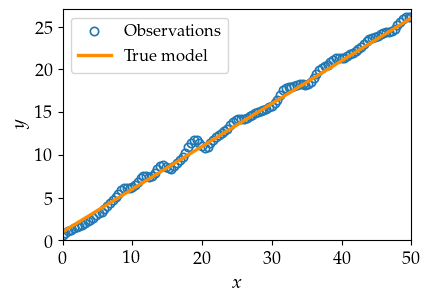

In [33]:
fig = plt.figure(figsize=(4.5,3))

# True value
w0 = 0.5
b0 = 1.0

# Initialize random number generator
np.random.seed(222)

# interval of x
xl = 0.0
xu = 50.0

# Total size of obervations
Nobs = 1001
x = np.linspace(xl, xu, Nobs)

# In order to avoid singular
coefficient = 1E-6
b = coefficient*np.identity(Nobs)
C = kernel(x,x) + b
m = np.zeros(Nobs)

y1 = w0*x + b0
# observations
y = w0*x + b0 + np.random.multivariate_normal(m,C)

plt.plot(x[0::8],y[0::8],'o',markerfacecolor='none', ms=6, markeredgecolor='C0',markeredgewidth=1.2,label='Observations')
plt.plot(x,y1,color='darkorange',linewidth=2.4,label='True model')
plt.xlabel(r'$x$',fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim([0,50])
plt.ylim([0,27])
plt.legend(fontsize=12)
plt.savefig('../figs-new/dns-like-data.pdf',bbox_inches='tight')
plt.show()

# Calculate with PyMC3

In [34]:
# PyMC3 Model help function
# PyMC3 model without covariance
def model_help(basic_model, data, x):    
    with basic_model:
        #prior
        w = pm.Normal('w', mu=0.8, sd=2.0)
        b = pm.Normal('b', mu=1.0, sd=2.0)
        mu = w*x + b
        y_o = pm.Normal('y_o', mu=mu, sd=0.5, observed=data)
        trace = pm.sample(5000)
    return trace

# PyMC3 model with covariance
def model_help_c(basic_model, data, x, C):    
    with basic_model:
        w = pm.Normal('w', mu=0.8, sd=2.0)
        b = pm.Normal('b', mu=1.0, sd=2.0)
        mu = w*x + b
        Y_obs = pm.MvNormal('Y_obs', mu=mu, cov=C, observed=data)
        trace = pm.sample(5000)
    return trace

In [35]:
# Results
posteriors = []
posteriors_C = []

#nObsUsed = np.array([2, 5, 10, 20, 50, 200, 500])

NobsUsed = np.array([2, 10, 50, 200, 500])

i = 1
for nSelected in NobsUsed:
    step = np.int(Nobs/nSelected)        
    print('# of observations:', nSelected, '; Stepsize = ', step)

    # Observations of each iteration
    x0 = x[::step]
    y0 = y[::step]
    
    #plt.figure(i)
    #plt.plot(x0, y0, 'o')
    #continue
    
    # calculate poteriors without covariance
    basic_model = pm.Model()
    trace = model_help(basic_model, y0, x0)
    posteriors.append(trace)
    
    # Kernel of observations
    C = kernel(x0,x0) + coefficient*np.identity(len(x0))
    
    # calculate poteriors with covariance
    basic_model_C = pm.Model()
    trace_C = model_help_c(basic_model_C,y0,x0,C)
    posteriors_C.append(trace_C)
    i+=1

/var/folders/j_/_ppj_xzj0ls56k7cq_gjkvnm0000gn/T/ipykernel_12922/4120220417.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  step = np.int(Nobs/nSelected)


# of observations: 2 ; Stepsize =  500


/var/folders/j_/_ppj_xzj0ls56k7cq_gjkvnm0000gn/T/ipykernel_12922/2539176738.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, w]


/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
/var/folders/j_/_ppj_xzj0ls56k7cq_gjkvnm0000gn/T/ipykernel_12922/2539176738.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_infer

/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
/var/folders/j_/_ppj_xzj0ls56k7cq_gjkvnm0000gn/T/ipykernel_12922/4120220417.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not m

# of observations: 10 ; Stepsize =  100


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, w]


/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/j_/_ppj_xzj0ls56k7cq_gjkvnm0000gn/T/ipykernel_12922/2539176738.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceDat

/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.880905441585973, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


# of observations: 50 ; Stepsize =  20


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, w]


/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8786269527286168, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.

/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/j_/_ppj_xzj0ls56k7cq_gjkvnm0000gn/T/ipykernel_12922/4120220417.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `

# of observations: 200 ; Stepsize =  5


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, w]


/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8787145148034681, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815328239

/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8818522080763596, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters

# of observations: 500 ; Stepsize =  2


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, w]


/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8806105100784888, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8848859626

/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8902280600954866, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters

In [125]:
# font1 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 9}
# Plot posteriors help function
def plot_posteriors(posteriors,posteriors_C,Ns):   
    iterate = len(posteriors)
    plot_transformed = False
    transform = identity_transform
    wp = np.zeros(iterate);stdw = np.zeros(iterate)
    bp = np.zeros(iterate);stdb = np.zeros(iterate)
    wpC = np.zeros(iterate);stdwC = np.zeros(iterate)
    bpC = np.zeros(iterate);stdbC = np.zeros(iterate)
    
    data_w = [];data_w_C = [];data_b = [];data_b_C = []
    for i in range(0, iterate):
        p = posteriors[i]
        varnames = get_default_varnames(p.varnames, plot_transformed)
        w = p.get_values(varnames[0], combine=False, squeeze=False)
        w = np.squeeze(transform(w))
        b = p.get_values(varnames[1], combine=False, squeeze=False)
        b = np.squeeze(transform(b))
        wp[i] = np.mean(w);stdw[i] = np.std(w)
        bp[i] = np.mean(b);stdb[i] = np.std(b)
        data_w.append(w);data_b.append(b)
        
        pC = posteriors_C[i]
        varnamesC = get_default_varnames(pC.varnames, plot_transformed)
        wC = pC.get_values(varnamesC[0], combine=False, squeeze=False)
        wC = np.squeeze(transform(wC))
        bC = pC.get_values(varnamesC[1], combine=False, squeeze=False)
        bC = np.squeeze(transform(bC))
        wpC[i] = np.mean(wC); stdwC[i] = np.std(wC)
        bpC[i] = np.mean(bC); stdbC[i] = np.std(bC)
        data_w_C.append(wC)
        data_b_C.append(bC)
        
    wl = wpC[0] - 2.5*stdwC[0]; wu = wpC[0] + 2.5*stdwC[0]
    bl = bpC[0] - 2.5*stdbC[0]; bu = bpC[0] + 2.5*stdbC[0]
    wplot = np.linspace(wl, wu, 400)
    bplot = np.linspace(bl, bu, 400)
    nn = np.zeros(iterate)
    maxw = np.zeros(iterate);maxb = np.zeros(iterate)
    #n = np.int(N/iterate);n0=n
    for i in range(0,iterate):
        nn[i] = Ns[i]
        # n += n0
    plt.figure(0)
    fig, axs = plt.subplots(1,2,figsize=(6.4, 3.6))
    axs = axs.ravel()
    for i in range(0,iterate):
        w_l = norm(wp[i],stdw[i]).pdf(wplot)
        w_lC = norm(wpC[i],stdwC[i]).pdf(wplot)
        maxw[i] = max(w_l)
        axs[0].plot(wplot,w_l,label='N=%d' % nn[i],linewidth=1.8)
        axs[1].plot(wplot,w_lC,label='N=%d' % nn[i],linewidth=1.8)
        #n += n0
    axs[0].legend(prop=font1);axs[1].legend(prop=font1)
    axs[0].set_xlabel(r'$w$, w/o covariance',fontsize=13)
    axs[1].set_xlabel(r'$w$, w/ covariance',fontsize=13)
    axs[0].set_ylabel('PDF',fontsize=13)
    maxpw = max(maxw)+5
    axs[0].axis([wl, wu, -1, maxpw])
    axs[1].axis([wl, wu, -1, maxpw])
    axs[0].tick_params(axis='x', labelsize=13)
    axs[0].tick_params(axis='y', labelsize=13)
    axs[1].tick_params(axis='x', labelsize=13)
    axs[1].tick_params(axis='y', labelsize=13)
    axs[0].legend(fontsize=10)
    axs[1].legend(fontsize=10)

    
    fig.tight_layout(pad=1.5)
    fig.savefig('../figs-new/W_posterior.pdf',bbox_inches='tight')
    plt.show()
    
#     plt.figure(1)
#     fig, axs = plt.subplots(1,2)
#     axs = axs.ravel()
#     for i in range(0,iterate):
#         b_l = norm(bp[i],stdb[i]).pdf(bplot)
#         maxb[i] = max(b_l)
#         b_lC = norm(bpC[i],stdbC[i]).pdf(bplot)
#         axs[0].plot(bplot,b_l,label='N=%d' % nn[i])
#         axs[1].plot(bplot,b_lC,label='N=%d' % nn[i])
#         #n += n0
#     axs[0].legend(prop=font1);axs[1].legend(prop=font1)
#     axs[0].set_xlabel('b without covariance')
#     axs[1].set_xlabel('b with covariance')
#     axs[0].set_ylabel('PDF')
#     maxpb = max(maxb)+0.5
#     axs[0].axis([bl, bu, -0.1, maxpb])
#     axs[1].axis([bl, bu, -0.1, maxpb])
# #     fig.savefig('b_posterior.pdf')
#     plt.show()
    
    plt.figure(2)
    fig, axs = plt.subplots(1,figsize=(3.05, 3.6))
#     axs = axs.ravel()
    for i in range(4,5):
        w_l = norm(wp[i],stdw[i]).pdf(wplot)
        w_lC = norm(wpC[i],stdwC[i]).pdf(wplot)
        axs.plot(wplot,w_l,label = 'w/o cov.',linewidth=1.8)
        axs.plot(wplot,w_lC,label = 'w/ cov.',linewidth=1.8)
        axs.axis([wl, wu, -1, maxpw])
        axs.legend(prop=font1)
        axs.set_xlabel(r'$w$',fontsize=13)
        axs.set_ylabel('PDF',fontsize=13)
        axs.tick_params(axis='x', labelsize=13)
        axs.tick_params(axis='y', labelsize=13)
        axs.legend(fontsize=10)
        #n += n0
    fig.savefig('../figs-new/compare-n500.pdf',bbox_inches='tight')
    plt.show()
    
#     plt.figure(3)
#     fig, axs = plt.subplots(1,iterate,figsize=(15, 6))
#     axs = axs.ravel()
#     for i in range(0,iterate):
#         b_l = norm(bp[i],stdb[i]).pdf(bplot)
#         b_lC = norm(bpC[i],stdbC[i]).pdf(bplot)
#         axs[i].plot(bplot,b_l,label = 'N=%d Nocov' % nn[i])
#         axs[i].plot(bplot,b_lC,label = 'N=%d Cov' % nn[i])
#         axs[i].axis([bl, bu, -0.1, maxpb])
#         axs[i].legend(prop=font1)
#         #n += n0
#     plt.show()
# #     fig.savefig('Compare-each-Ns.pdf')
    
#     plt.figure(4)
#     fig, axs = plt.subplots(2,1)
#     axs = axs.ravel()
#     axs[0].loglog(nn,stdw, '-o', label='No cov')
#     axs[0].loglog(nn,stdwC, '-s', label = 'cov')
#     axs[0].legend(prop=font1)
#     axs[0].set_ylabel('Std of w')
#     axs[1].loglog(nn,stdw, '-o', label='No cov')
#     axs[1].loglog(nn,stdwC, '-s', label = 'cov')
#     axs[1].legend(prop=font1)
#     axs[1].set_xlabel('Number of observations')
#     axs[1].set_ylabel('Std of b')
#     plt.show()
#     fig.savefig('std.pdf')

<Figure size 640x480 with 0 Axes>

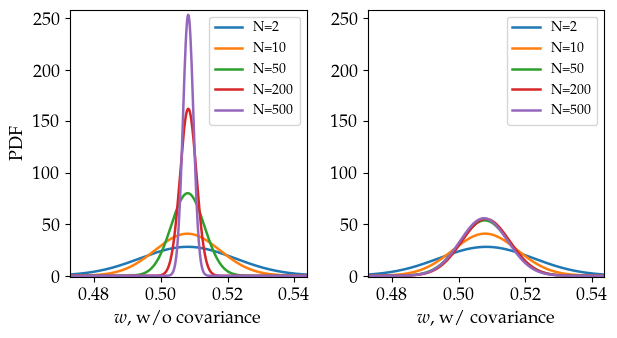

<Figure size 640x480 with 0 Axes>

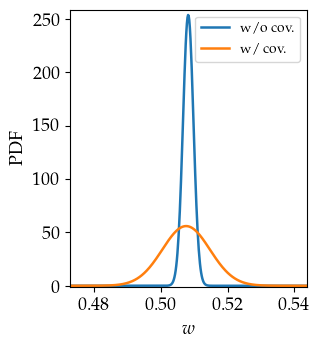

In [126]:
# plot results
NobsUsed = np.array([2, 10, 50, 200, 500])
plot_posteriors(posteriors, posteriors_C, NobsUsed)

# Conclusion

From the posteriors with and without covariace, several conclusion can be obtained:
     1. Covariance have significant influence on posteriors in Bayesian framework. Therefore, in practice engineering problems, we should be carefull of using Bayesian framework.
     2. With the increasing number of observations, the standard deviation of posteriors with covariance will not decrease shapely. It will decrease a little firstly, then  converge to a value.
     3. However,with the increasing number of observations, the standard deviation of posterior without covariance decreases shapely firstly then converges. This convergent value is much smaller than the corresponding value with covariance.